In [29]:
import pandas as pd
import numpy as np
import pipeline as py
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%matplotlib inline

sns.set(rc={'figure.figsize':(10, 5)})

## Reading the Data

In [32]:
claims = py.read_all()

In [33]:
claims.head(2)

,Unnamed: 0,reimb2010,reimb2008,reimb2009,age2010,male,race,heart.failure,kidney,cancer,...,OfficeVisit,EyeExam,EKG,xray,CTScan,PhysicalTherapy,Ambulance,acuity,costTrend,monthsWithClaims
0,0,390,320.0,360,97,0,White,0,0,0,...,4,1,0,1,0,0,0,0.235294,-0.018856,9
1,1,970,58800.0,2740,79,0,White,1,1,0,...,12,0,2,8,1,0,1,0.853591,-0.027265,21


## Minor Changes in Recording Errors in the Variables

In [34]:
claims["race"] = claims["race"].str.replace("Block", "Black")
claims = claims.drop(columns = ["Unnamed: 0"])

## Creating Binary Variables from Categorical Variables

In [35]:
claims = py.onehot(claims, ["race"])

## Health Care Costs Transformation

The distribution of healtcare costs is bounded on the lower end. It never reaches zero and ranges widely on the upper end. Sometimes the range can me in terms of million dollars depending on the condition. 

Text(0, 0.5, 'Density')

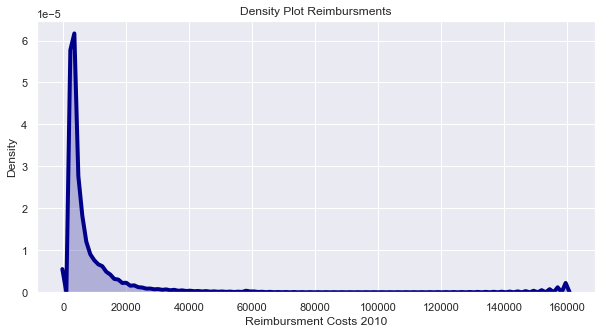

In [37]:
sns.distplot(claims["reimb2010"], hist = False, 
             kde = True, color = "darkblue", 
             kde_kws = {'shade': True, 'linewidth': 4})
plt.title('Density Plot Reimbursments')
plt.xlabel('Reimbursment Costs 2010')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

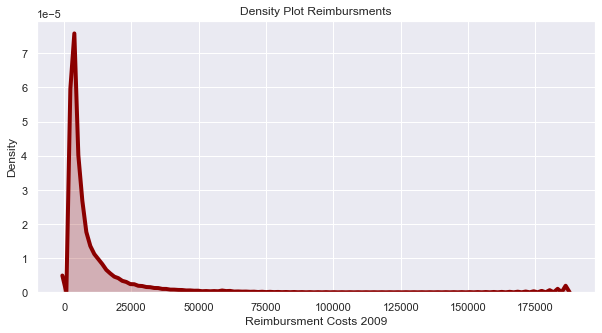

In [38]:
sns.distplot(claims["reimb2009"], hist = False, 
             kde = True, color = "darkred", 
             kde_kws = {'shade': True, 'linewidth': 4})
plt.title('Density Plot Reimbursments')
plt.xlabel('Reimbursment Costs 2009')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

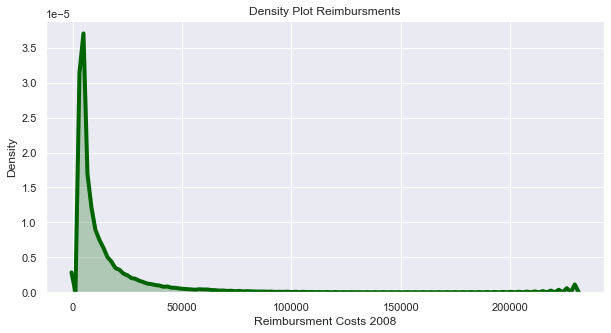

In [39]:
sns.distplot(claims["reimb2008"], hist = False, 
             kde = True, color = "darkgreen", 
             kde_kws = {'shade': True, 'linewidth': 4})
plt.title('Density Plot Reimbursments')
plt.xlabel('Reimbursment Costs 2008')
plt.ylabel('Density')

### One way to deal with this skewness is to take _log transformation_ of the variable and amend it into equal scale

In [40]:
claims["log(reimb2010+1)"] = np.array(claims["reimb2010"]) + 1
claims["log(reimb2010+1)"] = np.log10(claims["log(reimb2010+1)"])

In [41]:
claims["log(reimb2010+1)"] = np.array(claims["reimb2010"]) + 1
claims["log(reimb2010+1)"] = np.log10(claims["log(reimb2010+1)"])

In [42]:
claims["log(reimb2009+1)"] = np.array(claims["reimb2009"]) + 1
claims["log(reimb2009+1)"] = np.log10(claims["log(reimb2009+1)"])

In [43]:
claims["log(reimb2008+1)"] = np.array(claims["reimb2008"]) + 1
claims["log(reimb2008+1)"] = np.log10(claims["log(reimb2008+1)"])

Text(0, 0.5, 'Density')

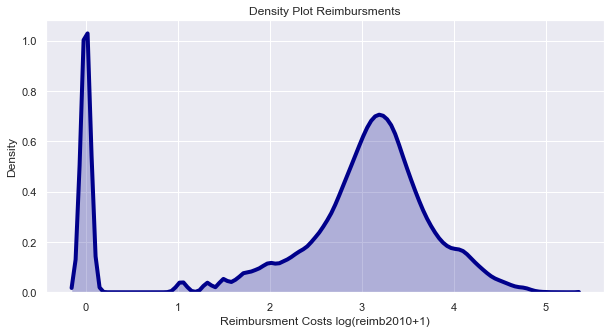

In [44]:
sns.distplot(claims["log(reimb2010+1)"], hist = False, 
             kde = True, color = "darkblue", 
             kde_kws = {'shade': True, 'linewidth': 4})
plt.title('Density Plot Reimbursments')
plt.xlabel('Reimbursment Costs log(reimb2010+1)')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

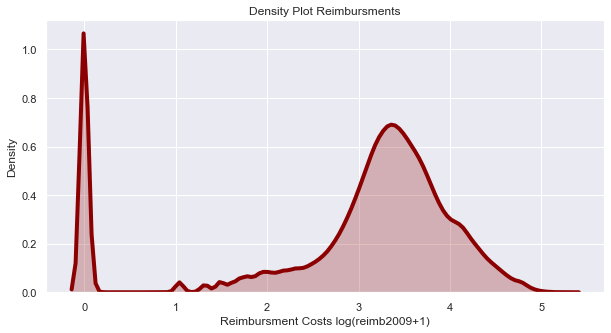

In [45]:
sns.distplot(claims["log(reimb2009+1)"], hist = False, 
             kde = True, color = "darkred", 
             kde_kws = {'shade': True, 'linewidth': 4})
plt.title('Density Plot Reimbursments')
plt.xlabel('Reimbursment Costs log(reimb2009+1)')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

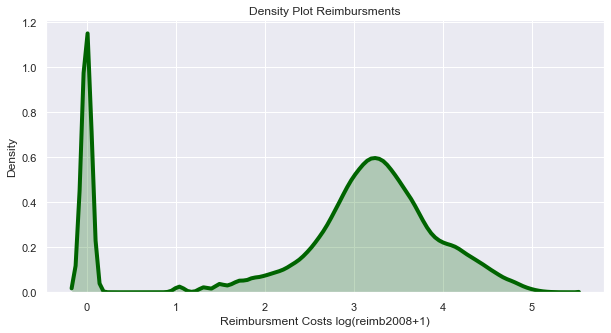

In [17]:
sns.distplot(claims["log(reimb2008+1)"], hist = False, 
             kde = True, color = "darkgreen", 
             kde_kws = {'shade': True, 'linewidth': 4})
plt.title('Density Plot Reimbursments')
plt.xlabel('Reimbursment Costs log(reimb2008+1)')
plt.ylabel('Density')

In [46]:
def write_data(claims):
    n = round(len(claims)/5)
    claims_datas = [claims[i:i+n] for i in range(0,claims.shape[0],n)]
    for index, data in enumerate(claims_datas):
        data.to_csv(f"Data/claims{index + 1}.csv", index = False)

In [47]:
write_data(claims)

## Creating Categorical Variable

For the purpose of this project we will have two types of target variables.

* Continious 

    - With linear regression models, we will use the continious cost variable to predict the reimbursment in 2010

* Categorical

    - With classifier models, we will use categorical (one hot encoded) cost 
    level variables to predict the level of reimbursment which we will use as a proxy for health

In [19]:
pd.DataFrame(claims["reimb2010"].describe().astype(int))

,reimb2010
count,1023948
mean,2843
std,5959
min,0
25%,240
50%,1120
75%,2620
max,160500


In [20]:
outliers = py.detect_outlier(claims["reimb2010"].to_list(), [])

In [21]:
min(outliers)

20730

* Any point above the lowest outlier point were marked as a _high_ cost. 
* Points between the 75th percentile and lowest outlier point were marked as _medium_ cost.
* The rest of the points were marked as _low_ cost.

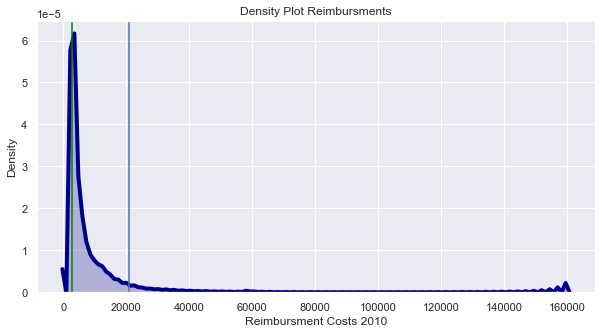

In [22]:
sns.distplot(claims["reimb2010"], hist = False, 
             kde = True, color = "darkblue", 
             kde_kws = {'shade': True, 'linewidth': 4})
plt.title('Density Plot Reimbursments')
plt.xlabel('Reimbursment Costs 2010')
plt.ylabel('Density')
plt.axvline(20730)
plt.axvline(2620, color = "green")

In [23]:
claims["cost_level"] = claims["reimb2010"].apply(lambda row:
                                                "High" if row >= 20730
                                                else ("Medium" if row < 20730 and row >= 2620
                                                     else "Low"))

In [24]:
claims = py.onehot(claims, ["cost_level"])

In [25]:
def write_data_2(claims):
    n = round(len(claims)/5)
    claims_datas = [claims[i:i+n] for i in range(0,claims.shape[0],n)]
    for index, data in enumerate(claims_datas):
        data.to_csv(f"Data/claims{index + 1}_categorical.csv", index = False)

In [26]:
write_data_2(claims)